In [51]:
# Import dependencies 
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats as stats
import pandas as pd
import datetime as dt

In [52]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc, distinct

In [53]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../SurfsUp/Resources/hawaii.sqlite")

In [54]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [55]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [56]:
# Use SQLAlchemy reflection to get the details of the Measurement table
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [57]:
# Use SQLAlchemy reflection to get the details of the Station table
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [58]:
# Create a session (link) from Python to the DB
session = Session(bind=engine)

In [59]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(desc('date')).first()
last_date

('2017-08-23')

In [60]:
# Calculate the date one year from the last date in data set.
latest_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
start_date = latest_date - dt.timedelta(days=365)
print(start_date)

2016-08-23 00:00:00


In [61]:
# Perform a query to retrieve the sum of the precipitation amount (across all stations) by date
# Sort the result by date
sel = [Measurement.date, 
       func.sum(Measurement.prcp)]
precipitation = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

In [62]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation, columns=['precipitation', 'Date'])
precipitation_df.set_index('Date')

# Convert object type to datetime object
precipitation_df["Date"] =precipitation_df["Date"].astype('datetime64[ns]')

In [63]:
# load query results into a Pandas dataframe

precipitation_df = pd.DataFrame(precipitation, columns = ["Date", "Precipitation"])

# set index to the date column

precipitation_df.set_index("Date", inplace=True)

precipitation_df

,Precipitation
Date,
2016-08-24,236.9
2016-08-25,13.6
2016-08-26,2.6
2016-08-27,8.1
2016-08-28,78.9
...,...
2017-08-19,2.3
2017-08-20,0.3
2017-08-21,14.7


In [64]:
# Design a query to retrieve the sum of the precipitation amount (across all stations) by date
# Sort the result by date
sel = [Measurement.date, 
       func.sum(Measurement.prcp)]
precipitation = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

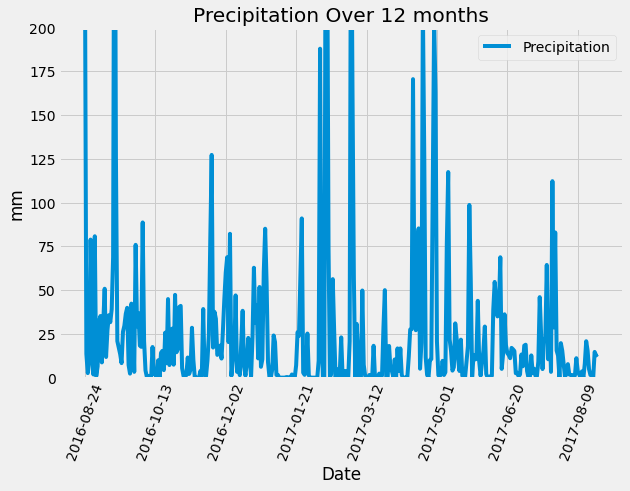

In [65]:
# plot precipitation results using Dataframe plot method
precipitation_plot = precipitation_df.plot(figsize=(9,6), ylim=(0,200), title = "Precipitation Over 12 months", rot=70)
precipitation_plot.set_ylabel("mm")
precipitation_plot.set_xlabel("Date")
plt.savefig("../SurfsUp/Annual_Precipitation_Hawaii.png")
plt.show()

In [66]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,365.000000
mean,24.760274
std,45.113719
min,0.000000
25%,1.400000
50%,10.100000
75%,27.500000
max,362.700000


In [67]:
# Design a query to show how many stations are available in this dataset.
total_stations = session.query(func.count(func.distinct(Measurement.station))).first()[0]
total_stations

9

In [68]:
# Finding the most active stations
# This query lists the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.date)]
active_stations = session.query(*sel).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [69]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
#highest temperature recorded, and average temperature of the most active station.
sel = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_temp_summary = session.query(*sel).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in station_temp_summary:
    print(station)

('USC00519281', 12.2, 29.4, 22.03582251082252)


In [70]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, 
       Measurement.tobs]
station_temps = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# Create a datafrem containing the results of this query
station_temps_df = pd.DataFrame(station_temps, columns=['Date', 'Temperature'])
station_temps_df.head()

,Date,Temperature
0,2016-08-24,25.0
1,2016-08-25,26.7
2,2016-08-26,26.7
3,2016-08-27,23.9
4,2016-08-28,22.8


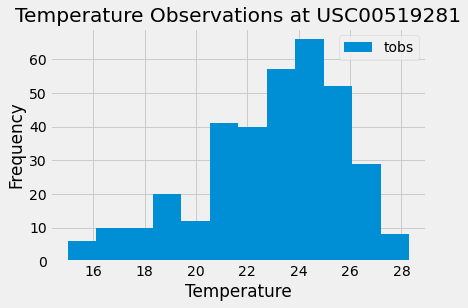

In [71]:
# Create a histogram to visualize the temperature observations from Station USC00519281 
plt.hist(station_temps_df['Temperature'],bins=12, density=False, label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations at USC00519281")
plt.figsize=(10,7)
plt.savefig('Annual_Temps_USC00519281.png',bbox_inches='tight')
plt.show()

In [72]:
# Close Session
session.close()